<h1 align=center><font size = 5><b>Brain tumor prediction project</b></font></h1>

<h3 align=center><font size = 3><b>A project by Boris Y. Nedyalkov</b></font></h3>
<h3 align=center><font size = 3>With data from: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection</font></h3>

<center> <img src="https://www.verywellhealth.com/thmb/QBYOi0JarA5dLYPHN2jLBEYOkYw=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-1190799984-ea0c55d36c014836b8244bf021d614b0.jpg" width=500, height=500 /></center> 

Image resource: https://www.verywellhealth.com/brain-cancer-5104754

In [27]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import pandas as pd

init_notebook_mode(connected=True)
RANDOM_SEED = 15
IMG_SIZE = (224,224)

## Crop and reformat the images

In [108]:
# some functions that one would need later in the code
# the functions are mostly from ruslankl (https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16)

def crop_imgs(img, add_pixels_value=0):
    """
    Finds the extreme points on the brain image and crops the image from there to the boundary, so to get a perfect brain image. (Also it resizes them to IMG_SIZE)
    """
    IMG_SIZE = (224,224)
    # resize
    img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    # resize
    new_img = cv2.resize(
            new_img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
    
    gray_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)

    return gray_img



def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

    
def set_plotter ():
    '''
    Plots the distribution of the train/test/val sets
    '''
    y = dict()
    y[0] = []
    y[1] = []
    for set_name in (y_train, y_val, y_test):
        y[0].append(np.sum(set_name == 0))
        y[1].append(np.sum(set_name == 1))

    trace0 = go.Bar(
        x=['Train Set', 'Validation Set', 'Test Set'],
        y=y[0],
        name='No',
        marker=dict(color='#33cc33'),
        opacity=0.7
    )
    trace1 = go.Bar(
        x=['Train Set', 'Validation Set', 'Test Set'],
        y=y[1],
        name='Yes',
        marker=dict(color='#ff3300'),
        opacity=0.7
    )
    data = [trace0, trace1]
    layout = go.Layout(
        title='Count of classes in each set',
        xaxis={'title': 'Set'},
        yaxis={'title': 'Count'}
    )
    fig = go.Figure(data, layout)
    iplot(fig)
    
    
    


def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()


        
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

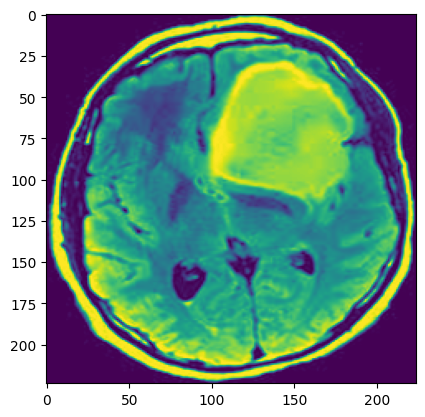

In [64]:
# lets see how it looks
img = cv2.imread('brain_tumor_dataset/yes/Y105.jpg')
cropped_img = crop_imgs(img)
plt.imshow(cropped_img)

In [37]:
# here we crop all the images and put them in a new folder
#IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
IMG_PATH = 'brain_tumor_dataset/'
DESTINATION_IMG_PATH = 'CROPPED_IMAGES/'
#TOT_NUM = len(os.listdir(IMG_PATH + 'no') + os.listdir(IMG_PATH + 'yes'))

labels = []
data = np.empty(224*224)

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))

        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img_path = IMG_PATH + CLASS + '/' + FILE_NAME
            destination_img_path = DESTINATION_IMG_PATH + CLASS + '/' + FILE_NAME
            img = cv2.imread(img_path)
            cropped_img = crop_imgs(img)
            
            # write the images in new folders
            cv2.imwrite(destination_img_path, img)

## Separate the data in sets

Make separate: train, validation and test sets

In [46]:
#IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
IMG_PATH = 'CROPPED_IMAGES/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 10:
                shutil.copy(img, 'DATA_SETS/TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'DATA_SETS/TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'DATA_SETS/VAL/'+ CLASS.upper() + '/' + FILE_NAME)



In [48]:
TRAIN_DIR = 'DATA_SETS/TRAIN/'
TEST_DIR = 'DATA_SETS/TEST/'
VAL_DIR = 'DATA_SETS/VAL/'

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]
C:\Users\Smelly_Giraffe\AppData\Local\Temp\ipykernel_14536\2640943180.py:67: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



183 images loaded from DATA_SETS/TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.97it/s]


20 images loaded from DATA_SETS/TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]

50 images loaded from DATA_SETS/VAL/ directory.


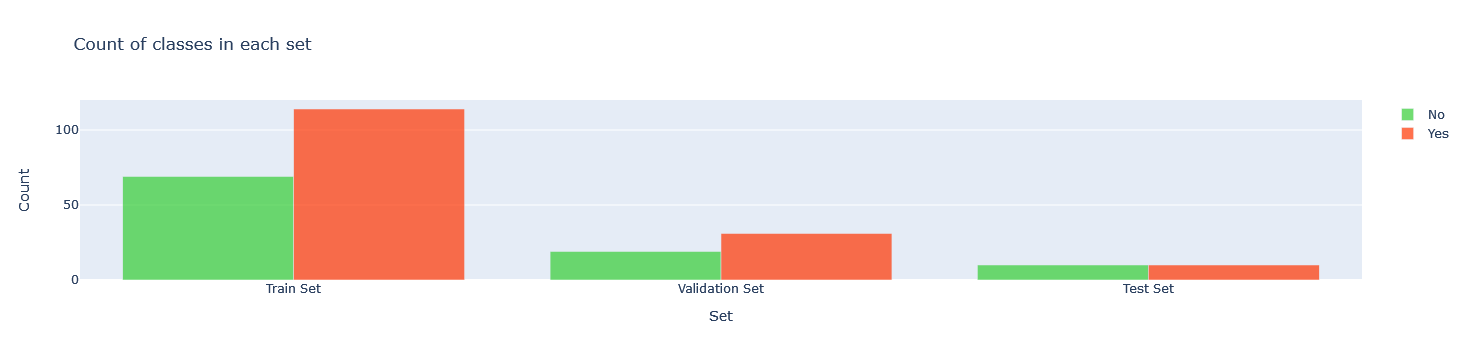

In [61]:
set_plotter ()

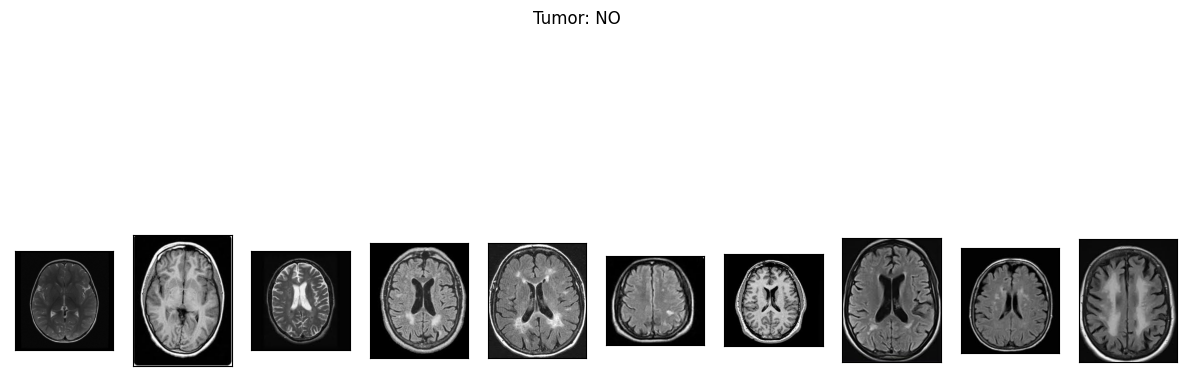

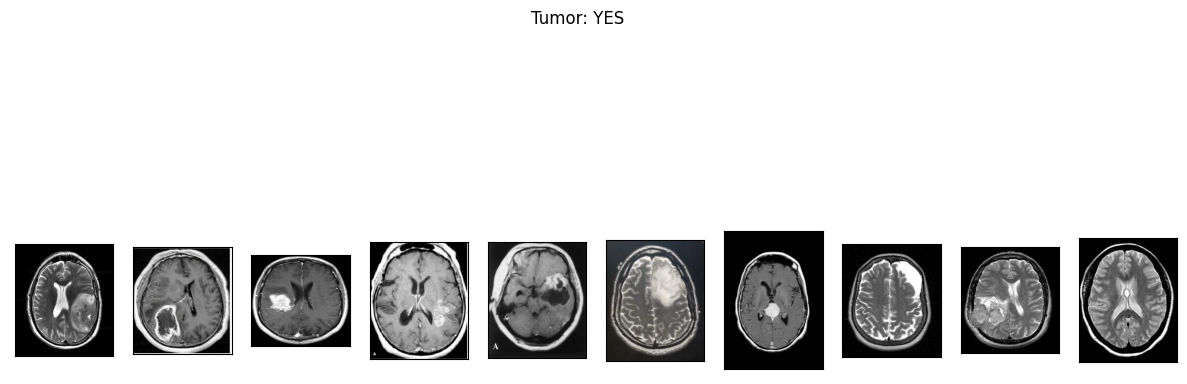

In [63]:
plot_samples(X_train, y_train, labels, 10)

# CNN Model

Done with transfer learning from the VGG-16 model

## Data Augumentation

In [ ]:
###################

In [65]:
# prepare the data generators (with augumentation for tran/val sets and without for the test set)

# set the paramters we want to change randomly
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [84]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 183 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Loading the model

In [85]:
# load base model
#vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_weight_path = 'VGG-16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [86]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [98]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=5,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3,
    callbacks=[es]
)

Epoch 1/30
5/5 [==============================] - 52s 11s/step - loss: 3.7974 - accuracy: 0.6556 - val_loss: 0.9374 - val_accuracy: 0.7917
Epoch 2/30
5/5 [==============================] - 60s 13s/step - loss: 3.0693 - accuracy: 0.6687 - val_loss: 0.9094 - val_accuracy: 0.8125
Epoch 3/30
5/5 [==============================] - 64s 13s/step - loss: 2.7861 - accuracy: 0.6750 - val_loss: 0.9217 - val_accuracy: 0.8333
Epoch 4/30
5/5 [==============================] - 63s 13s/step - loss: 2.7943 - accuracy: 0.7086 - val_loss: 0.8577 - val_accuracy: 0.8333
Epoch 5/30
5/5 [==============================] - 60s 13s/step - loss: 2.4577 - accuracy: 0.7219 - val_loss: 0.8215 - val_accuracy: 0.8333
Epoch 6/30
5/5 [==============================] - 61s 13s/step - loss: 3.2494 - accuracy: 0.6556 - val_loss: 0.8003 - val_accuracy: 0.8333
Epoch 7/30
5/5 [==============================] - 59s 12s/step - loss: 2.3934 - accuracy: 0.6887 - val_loss: 0.7464 - val_accuracy: 0.8333
Epoch 8/30
5/5 [===========

In [96]:
len(X_val)/16

3.125

Text(0.5, 1.0, 'Train - Accuracy')

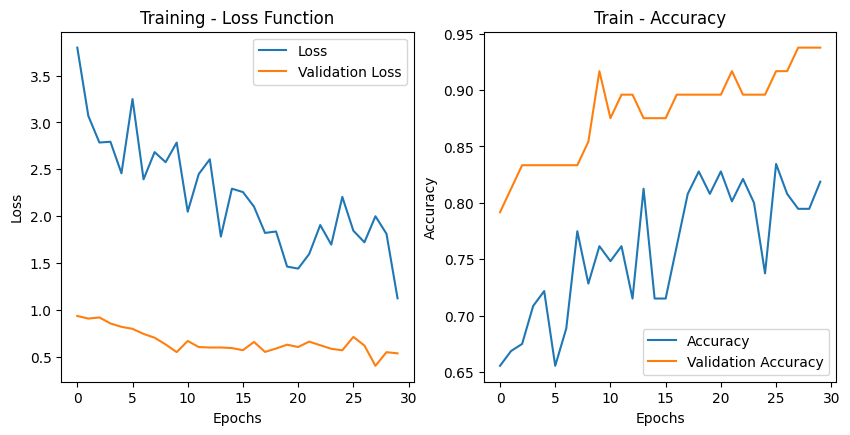

In [106]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train - Accuracy')

2/2 [==============================] - 11s 4s/step
Val Accuracy = 0.92


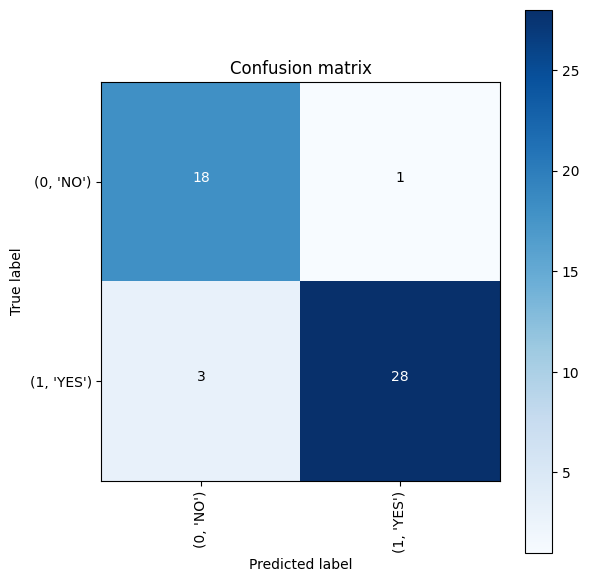

In [109]:
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

1/1 [==============================] - 4s 4s/step
Test Accuracy = 0.85


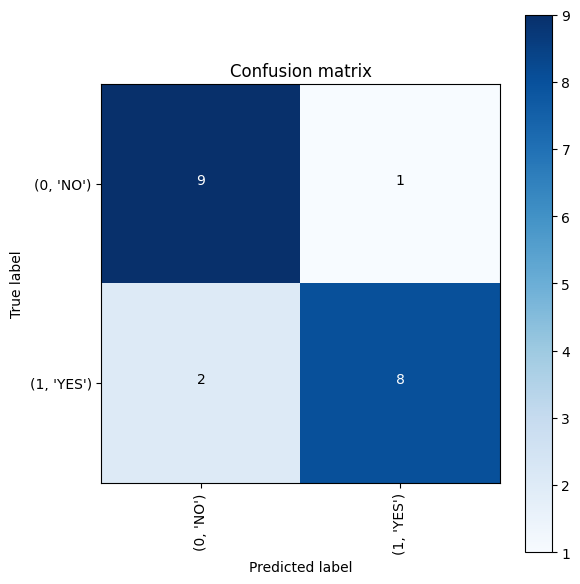

In [111]:
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)

# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



## Conclusions

The hyperparameter can be further tuned and more epochs introduced. Thus training the NN to even better accuracy. The current model achieved for true label "YES" (has cancer):

* Test accuracy - 85%.
* Recall - 80%
* Precision - 89%

A good thing to show further is the Precision-Recall curve and adjust for 100% Recall there. To make sure no patients go undiagnosed.

In [116]:
# def  PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name'):
    
#     from sklearn.metrics import  precision_recall_curve

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=120)
#     fig.suptitle('PR-plots')

#     precision, recall, thresholds = precision_recall_curve(y_train,y_proba_train[:,1])
#     sns.scatterplot(ax = ax1, x=recall, y=precision)
#     ax1.set_xlabel('Recall')
#     ax1.set_ylabel('Precision')
#     ax1.set_title('Train Data')

#     precision2, recall2, thresholds2 = precision_recall_curve(y_test,y_proba_test[:,1])
#     sns.scatterplot(ax = ax2, x=recall2, y=precision2)
#     ax2.set_xlabel('Recall')
#     ax2.set_ylabel('Precision')
#     ax2.set_title('Test Data')
    
#     plt.show()
    
#     # data ={'Recall_train':recall,
#     #        'Prеcision_train':precision,
#     #        'Recall_test':recall2,
#     #        'Prеcision_test':precision2}
#     # datafrtrain = pd.DataFrame('Recall_train':recall,
#     #        'Prеcision_train':precision)
    
#     return  precision, recall, precision2, recall2

In [117]:
# y_proba_train = model.predict_proba(X_train)
# y_proba_test = model.predict_proba(X_test)

# PRplotter(y_train, y_proba_train, y_test, y_proba_test, name='name')